In [1]:

import numpy as np
import _pickle as Pickle
import gzip
import os.path
import random
import matplotlib.pyplot as plt


In [2]:
%pip install numba
%pip install numba-scipy
from numba import jit, uint64

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:

#First try at creating a neural nett, used code from https://github.com/MichalDanielDobrzanski/DeepLearningPython but have
# reached a dead end at the moment, someting wrong with the dot product i'm doing. Gonna pick up another time. 


f = gzip.open("mnist_expanded.pkl.gz", 'rb')
    
imported = Pickle.Unpickler(file=f, encoding='latin1')
training_data, validation_data, test_data = imported.load()
    
f.close()

In [4]:


class Network(object):
 
    def __init__(self, sizes, weights = None, biases = None):
        self.sizes = sizes 
        self.biases =  [np.random.randn(y, 1) for y in sizes[1:]] #creates an array of weights randomized from the standard normal function
        self.weights = [np.random.randn(y, x) for y,x in zip(sizes[:-1], sizes[1:])] #same but takes in the number of neurons in one layer and creates weights connection to each neuron in the next
        
        if weights:
            self.weights = weights 
        else:
            print("hi")
        if biases: 
            self.biases = biases 
        else:
            print("hi")
            
    def feedforward(self, a): #takes in a which is a list of inputs from any layer in the neural nett. 
        for b, w in zip(self.biases, self.weights): #zips an tuple consisting of the bias and weigths for a neuron and then 
            n_a = np.zeros(len(w[1]))
            
            for k in range(len(b)):
                n_a[k] += b[k]
            print(len(w))
            for i in range(len(w)):
                j=0
                for items in w[i]:
                    
                    
                    n_a[j]= n_a[j] + items*a[i]
                    j+=1
            
                
            a = n_a
            a = sigmoid(a)
          
          
            
            #and then applies the sigmoid function, could perhaps use a different function here. 
            #print(np.shape(a))
        return a   
    

    def SGD(self, training_data, epochs, mini_batch_size , eta, test_data = None):
        training_data = list(training_data)
        n = len(training_data) #creates opreable data
        
        if test_data:
            test_data = list(test_data)
            n_test = len(test_data) 
        
        for j in range(epochs ):
            random.shuffle(training_data) 
            mini_batches = [
            training_data[k:k+mini_batch_size] # divides the training data into smaller portions
            for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                print(mini_batch)
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print("Epoch {} : {} / {}", format(j,self.evaluate(test_data),n_test))
            else:
                print("Epoch {} complete", (j))
                
   
    def update_mini_batch(self, mini_batch, eta):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
    
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]
        
       
    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

  
    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)
    
  
    def evaluate_one(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        
        
        test_results = self.feedforward(test_data)
        return test_results
    
    
    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)
    
#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))
        
    


In [5]:
net = Network([784, 30, 10])
#net.SGD(training_data, 10, 30, 3.0)

hi
hi


In [6]:
result_b = list(training_data)

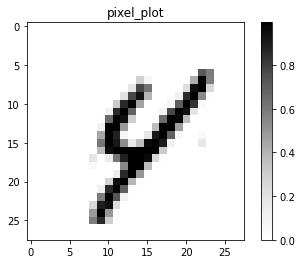

the soulution is 4
2


In [12]:
a =int(random.random()*10000)

test_image = training_data[0]
test_image_answer = training_data[1] 
test_image_answer = test_image_answer[a]
test_image = test_image[a]


data = np.zeros((28,28))
i = 0
for x in range(28):
    for y in range(28):
        data[x,y]=test_image[i]
        i+=1
        
        
plt.figure()

plt.title("pixel_plot")
plt.imshow(data, cmap='Greys', interpolation='nearest') 
plt.colorbar()
plt.savefig('pixel_plot.png')
plt.show()
print("the soulution is", test_image_answer)


print(len(result_b))

#result  = net.evaluate(result_b) 





In [14]:
weights = net.weights 
biases = net.biases 


In [15]:
print(len(weights[1]))
print(len(biases[0]))

30
30


In [ ]:
sizes = [2,2,2,2]
a = [np.random.randn(y, x) for y,x in zip(sizes[:-1], sizes[1:])]
b = [np.random.randn(y, 1) for y in sizes[1:]]
#print(a)
c =list(zip(b,a))
print(c[0])test_data1 = test_data[random]